In [40]:
#Importing all needed librarys
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from tqdm import tqdm
from torch import nn, optim
import seaborn as sns
import torch.nn.functional as F

# importing the libraries
import pandas as pd
import numpy as np

# for creating validation set
from sklearn.model_selection import train_test_split


import torchvision
from torchvision.datasets import ImageFolder

In [41]:
#Checking wich GPU is beeing used

!nvidia-smi

Thu Dec  2 16:14:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   39C    P8    18W / 250W |   7783MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 31%   

In [42]:
#Load data
data_speaker1_dir = 'dialogue/Dataset/SameVoiceDetection/2d_dataset/less_251_5_speaker1.npy'
#data_speaker1_dir = 'dialogue/Leander/outputs/speaker1.npy'
data_speaker2_dir = 'dialogue/Dataset/SameVoiceDetection/2d_dataset/less_251_5_speaker2.npy'
#data_speaker2_dir = 'dialogue/Leander/outputs/speaker2.npy'
labels_dir = 'dialogue/Dataset/SameVoiceDetection/2d_dataset/less_251_5_labels.npy'
#labels_dir = 'dialogue/Leander/outputs/labels.npy'

data_speaker1 = np.load(data_speaker1_dir, allow_pickle = True)
data_speaker2 = np.load(data_speaker2_dir, allow_pickle = True)
#data_speaker1 = data_speaker1.reshape((len(data_speaker1),40,len(data_speaker1[0])//40))
#data_speaker2 = data_speaker2.reshape((len(data_speaker2),40,len(data_speaker2[0])//40))
labels = np.load(labels_dir, allow_pickle = True)

print(data_speaker1.shape, data_speaker2.shape)
print(labels)

(504008, 40, 16) (504008, 40, 16)
[ True False  True ... False  True False]


In [43]:
#df_data.drop(['isSpeaking'],axis = 1)
X1_train, X1_val, y_train, y_val = train_test_split(data_speaker1, labels, test_size = 0.2, random_state = 23)
X1_train, X1_test, y_train, y_test = train_test_split(X1_train, y_train, test_size = 0.2, random_state = 23)

X2_train, X2_val, y_train, y_val = train_test_split(data_speaker2, labels, test_size = 0.2, random_state = 23)
X2_train, X2_test, y_train, y_test = train_test_split(X2_train, y_train, test_size = 0.2, random_state = 23)

print(type(X1_train))
#print(X_train)

<class 'numpy.ndarray'>


In [44]:
X1_train = torch.from_numpy(X1_train).float()

X2_train = torch.from_numpy(X2_train).float()

y_train = torch.from_numpy(y_train).float()

X1_val = torch.from_numpy(X1_val).float()

X2_val = torch.from_numpy(X2_val).float()

y_val = torch.from_numpy(y_val).float()

X1_test = torch.from_numpy(X1_test).float()

X2_test = torch.from_numpy(X2_test).float()

y_test = torch.from_numpy(y_test).float()

print(X2_train.shape, y_train.shape)

print(X2_train[0])


torch.Size([322564, 40, 16]) torch.Size([322564])
tensor([[-5.3371e+02, -4.2347e+02, -3.3977e+02, -2.7539e+02, -2.2160e+02,
         -1.6781e+02, -1.5767e+02, -2.1003e+02, -3.0699e+02, -4.5837e+02,
         -4.2851e+02, -3.4132e+02, -2.3138e+02, -2.0375e+02, -2.3189e+02,
         -2.5337e+02],
        [ 1.2088e+02,  1.6142e+02,  1.9561e+02,  2.0534e+02,  1.6590e+02,
          1.1133e+02,  7.5165e+01,  6.0036e+01,  8.1754e+01,  6.7257e+01,
          1.9314e+00, -6.5979e+00,  6.9351e+01,  1.3058e+02,  1.6934e+02,
          1.7825e+02],
        [-1.6849e+00, -1.7748e+01, -3.4412e+01, -8.0094e+01, -1.1451e+02,
         -1.0499e+02, -8.3728e+01, -5.8260e+01, -5.4963e+01, -6.0335e+00,
         -2.0590e+01, -2.0809e+01, -1.3073e+01, -4.0493e+01, -7.3653e+01,
         -5.9857e+01],
        [-2.3717e+01, -4.6973e+00,  2.0056e+01,  2.4913e+01,  3.9538e+01,
          6.3902e+01,  8.3147e+01,  1.1351e+02,  1.3468e+02,  9.3629e+01,
          5.4036e+01,  3.7534e+01,  1.5739e+01,  5.2855e+00,  6.992

In [45]:
class model(nn.Module):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()
        self.conv1 = nn.Conv1d(n_features, 40, kernel_size=3, stride = 1) #40 input channels, 40 output channels
        self.conv2 = nn.Conv1d(40, 80, kernel_size=3, stride = 1) #40 input channels from previous Conv. layer, 80 out
        
        self.fc1 = nn.Linear(320, 100) #Fully-connected classifier layer 
        self.fc2 = nn.Linear(100, 1) #Fully-connected classifier layer
    
    def forward_one_voice(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        x = F.relu(F.max_pool1d(self.conv2(x), 2))
        
        x = x.reshape(len(x), -1)
        batch_size = len(x)
        
        return x
    
    def forward(self, x1, x2):
        x1 = self.forward_one_voice(x1)
        x2 = self.forward_one_voice(x2)
        x = torch.concat([x1, x2], axis = 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return torch.sigmoid(x)
    
    def post_forward(self, y): 
        return torch.round(y)
    
CNN = model(X1_train.shape[1],kernel_size = 3)

In [46]:
weight = torch.FloatTensor([1])
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.00003)

In [47]:
train_ds = TensorDataset(X1_train, X2_train, y_train)
val_ds = TensorDataset(X1_val, X2_val, y_val)

In [48]:
train_dl = DataLoader(train_ds, batch_size=64, num_workers = 4, pin_memory = True)
#val_dl = DataLoader(val_ds, batch_size= 32)

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X1_train = X1_train.to(device)
# X2_train = X2_train.to(device)
# y_train = y_train.to(device)
X1_val = X1_val.to(device)
X2_val = X2_val.to(device)
y_val = y_val.to(device)

X1_test = X1_test.to(device)
X2_test = X2_test.to(device)
y_test = y_test.to(device)

CNN = CNN.to(device)
criterion = criterion.to(device)
print(device)

cuda


In [50]:
def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().float() / len(y_true)

In [51]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

Results = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_val', 'val_loss', 'train_loss'])
    
for epoch in range(100):
        for x1, x2, y in train_dl:
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = CNN(x1, x2)
            y_pred = y_pred.squeeze()
            train_loss = criterion(y_pred, y)
            train_loss.backward()
            optimizer.step()
        if epoch % 1 == 0:
        
            train_acc = calculate_accuracy(y, CNN.post_forward(y_pred))
        
            y_val_pred = CNN(X1_val, X2_val)
            y_val_pred = y_val_pred.squeeze()
            val_loss = criterion(y_val_pred, y_val)
        
            val_acc = calculate_accuracy(y_val, CNN.post_forward(y_val_pred))
        
            result = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_val': round_tensor(val_acc), 'val_loss': round_tensor(val_loss), 'train_loss': round_tensor(train_loss)}

            Results = Results.append(result, ignore_index=True)

            print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
val  set - loss: {round_tensor(val_loss)}, accuracy: {round_tensor(val_acc)}
''')
        
        
        


epoch 0
Train set - loss: 0.277, accuracy: 1.0
val  set - loss: 0.481, accuracy: 0.769

epoch 1
Train set - loss: 0.224, accuracy: 1.0
val  set - loss: 0.424, accuracy: 0.805

epoch 2
Train set - loss: 0.269, accuracy: 0.75
val  set - loss: 0.399, accuracy: 0.819

epoch 3
Train set - loss: 0.295, accuracy: 0.75
val  set - loss: 0.38, accuracy: 0.83

epoch 4
Train set - loss: 0.338, accuracy: 0.75
val  set - loss: 0.363, accuracy: 0.84

epoch 5
Train set - loss: 0.367, accuracy: 0.75
val  set - loss: 0.35, accuracy: 0.847

epoch 6
Train set - loss: 0.363, accuracy: 0.75
val  set - loss: 0.339, accuracy: 0.852

epoch 7
Train set - loss: 0.373, accuracy: 0.75
val  set - loss: 0.331, accuracy: 0.856

epoch 8
Train set - loss: 0.375, accuracy: 0.75
val  set - loss: 0.325, accuracy: 0.859

epoch 9
Train set - loss: 0.365, accuracy: 0.75
val  set - loss: 0.319, accuracy: 0.862

epoch 10
Train set - loss: 0.353, accuracy: 0.75
val  set - loss: 0.314, accuracy: 0.864

epoch 11
Train set - loss:

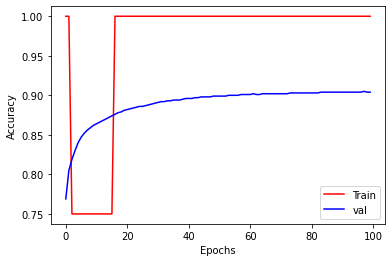

    Epoch  Acc_train  Acc_val  val_loss  train_loss
0     0.0       1.00    0.769     0.481       0.277
1     1.0       1.00    0.805     0.424       0.224
2     2.0       0.75    0.819     0.399       0.269
3     3.0       0.75    0.830     0.380       0.295
4     4.0       0.75    0.840     0.363       0.338
..    ...        ...      ...       ...         ...
95   95.0       1.00    0.904     0.244       0.052
96   96.0       1.00    0.904     0.244       0.052
97   97.0       1.00    0.905     0.244       0.050
98   98.0       1.00    0.904     0.244       0.049
99   99.0       1.00    0.904     0.245       0.045

[100 rows x 5 columns]


In [52]:
plt.plot(Results.Epoch,Results.Acc_train,'r',Results.Epoch,Results.Acc_val,'b')
plt.legend(['Train','val'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
print(Results)

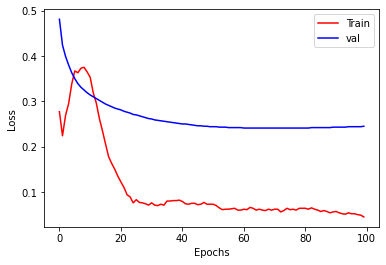

In [53]:
plt.plot(Results.Epoch,Results.train_loss,'r',Results.Epoch,Results.val_loss,'b')
plt.legend(['Train','val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [54]:
classes = ['Different Voice', 'Same Voice']
y_pred = CNN(X1_val, X2_val)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()
print(classification_report(y_val, y_pred, target_names=classes))

                 precision    recall  f1-score   support

Different Voice       0.91      0.90      0.90     50344
     Same Voice       0.90      0.91      0.91     50458

       accuracy                           0.90    100802
      macro avg       0.90      0.90      0.90    100802
   weighted avg       0.90      0.90      0.90    100802



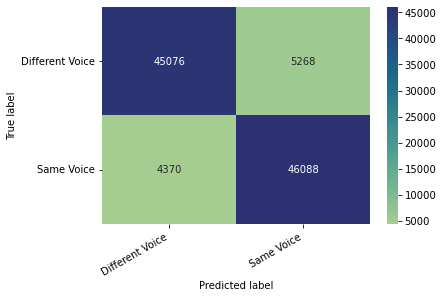

In [55]:
cm = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [56]:
y_pred = CNN(X1_test, X2_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

                 precision    recall  f1-score   support

Different Voice       0.91      0.90      0.91     40517
     Same Voice       0.90      0.92      0.91     40125

       accuracy                           0.91     80642
      macro avg       0.91      0.91      0.91     80642
   weighted avg       0.91      0.91      0.91     80642



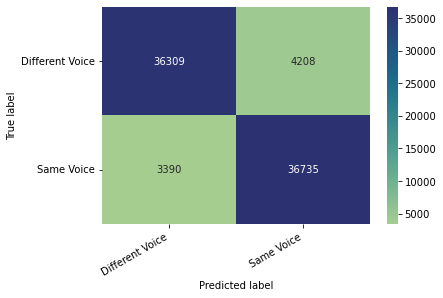

In [57]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [58]:
#Shutting down the notebook

%%javascript
Jupyter.notebook.session.delete();

UsageError: Line magic function `%%javascript` not found.
